In [1]:
# Parameters
attr_path = "/srv/stemly/data/6/index/2/attributes/attributes.csv"
index_path = "/srv/stemly/data/6/index/2/index/index.csv"
committed_files = ["/srv/stemly/data/6/index/2/timeseries/552/commit/ts.0/9.1660802678268.parquet"]
predict_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/25/ts.predict.latest.parquet"
test_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/25/ts.test.latest.parquet"
validate_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/25/ts.validate.latest.parquet"
model = "custom"
model_file_id = "42"
model_resolution = None
reference_resolution = "W-MON"
project_offset = 4
project_periods = 48
project_resolution = "W-MON"
ts_train_start = "2021-08-23 00:00:00"
ts_train_v_end = "2022-06-20 00:00:00"
ts_train_t_end = "2022-06-06 00:00:00"
ts_train_p_end = "2022-07-04 00:00:00"
ts_test_start = "2022-06-06 00:00:00"
ts_test_end = "2022-06-20 00:00:00"
ts_test_duration = 2
ts_validate_start = "2022-06-20 00:00:00"
ts_validate_end = "2022-07-04 00:00:00"
ts_validate_duration = 2
ts_predict_start = "2022-07-04 00:00:00"
ts_predict_end = "2023-06-05 00:00:00"
ts_predict_duration = 48
redis_url = "redis://127.0.0.1:6300"
job_id = "cf6a6059-e3a5-424e-b7e8-ceba2ba15554"
job_user_id = "3"
resource_id = "25"
resource_version = 1661425215465
resource_type = "modelbase"
workspace_id = "6"
job_name = "custom"
job_triggered_at = "2022-08-25 11:00:15"
job_triggered_by = "Mallikarjuna Reddy Padigapati"


In [2]:
# ML Models

!pip install pandarallel --user
!pip install prophet --user
!pip install pyarrow --user
!pip install lightgbm --user

!pip install numpy --user
!pip install matplotlib --user
!pip install seaborn --user
!pip install tqdm --user
!pip install p_tqdm --user
!pip install plotly --user
!pip install sklearn --user

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.express as px
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from feature_engineering import get_features
from feature_engineering import mean_encode
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [4]:

ts_files = committed_files
joining_keys=["ts", "id"]
attr_cols=None

if joining_keys is None:
    joining_keys = ["ts", "id"]

at = pd.read_csv(attr_path)

idx = pd.read_csv(index_path)

# timeseries data
df = pd.concat([pd.read_parquet(fp) for fp in ts_files])
df = df.groupby(joining_keys).sum().reset_index()
df = pd.merge(df, at , left_on=["id"], right_on=["__idx"], how="left")
df.head()

,ts,id,y,cases,description,level2,prod_code,prod_hierarchy,size,sku,sku_desc,sku_type,units,__idx
0,2021-08-23,1,1.0,57,FAB CLEANSER EUP 142G(50Z)X57 NONSTK,NaN,10024916,FAB,5.0,80702886,FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [80702886] (00851939002005),Cleanser,Oz,1
1,2021-08-23,3,8.0,69,FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23,Ultra Repair,10024914,FAB,1.7,82332207,FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [82332207] (00815517024018),Serum,Oz,3
2,2021-08-23,4,21.0,42,FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK,Ultra Repair,9222618,FAB,2.0,82332208,FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332208] (00851939002449),Cream,Oz,4
3,2021-08-23,5,8.0,48,FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK,Ultra Repair,10024913,FAB,6.0,82332219,FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [82332219] (00815517024728),Toner,Oz,5
4,2021-08-23,6,6.0,48,FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK,Ultra Repair,10080881,FAB,6.0,82332800,FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800] (00851939002210),Toner,Oz,6


In [5]:

df["year"] = df.ts.dt.year
df["month"] = df.ts.dt.month
df["woy"] = df.ts.dt.isocalendar().week
df["woy"] = df["woy"].astype(int)

In [6]:
df.head()

,ts,id,y,cases,description,level2,prod_code,prod_hierarchy,size,sku,sku_desc,sku_type,units,__idx,year,month,woy
0,2021-08-23,1,1.0,57,FAB CLEANSER EUP 142G(50Z)X57 NONSTK,NaN,10024916,FAB,5.0,80702886,FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [80702886] (00851939002005),Cleanser,Oz,1,2021,8,34
1,2021-08-23,3,8.0,69,FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23,Ultra Repair,10024914,FAB,1.7,82332207,FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [82332207] (00815517024018),Serum,Oz,3,2021,8,34
2,2021-08-23,4,21.0,42,FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK,Ultra Repair,9222618,FAB,2.0,82332208,FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332208] (00851939002449),Cream,Oz,4,2021,8,34
3,2021-08-23,5,8.0,48,FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK,Ultra Repair,10024913,FAB,6.0,82332219,FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [82332219] (00815517024728),Toner,Oz,5,2021,8,34
4,2021-08-23,6,6.0,48,FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK,Ultra Repair,10080881,FAB,6.0,82332800,FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800] (00851939002210),Toner,Oz,6,2021,8,34


In [7]:
df.shape

(339, 17)

### Begin Forecasting Below

## Dates

In [8]:
df.id.unique()

array([1, 3, 4, 5, 6, 7, 0, 2])

In [9]:
df.ts.min(), df.ts.max()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2022-07-18 00:00:00'))

In [10]:
forecast_dates = pd.date_range(
    start=ts_predict_start,
    end=ts_predict_end,
    freq="W-Mon",
)
forecast_dates = forecast_dates[1:]
forecast_dates

DatetimeIndex(['2022-07-11', '2022-07-18', '2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05'], dtype='datetime64[ns]', freq='W-MON')

In [11]:
val_dates = pd.date_range(
    start=ts_validate_start,
    end=ts_validate_end,
    freq="W-Mon",
)
val_dates = val_dates[1:]
print(len(val_dates))
val_dates

2


DatetimeIndex(['2022-06-27', '2022-07-04'], dtype='datetime64[ns]', freq='W-MON')

In [12]:
test_dates = pd.date_range(
    start=ts_test_start,
    end=ts_test_end,
    freq="W-Mon",
)
test_dates = test_dates[1:]
print(len(test_dates))
test_dates

2


DatetimeIndex(['2022-06-13', '2022-06-20'], dtype='datetime64[ns]', freq='W-MON')

In [13]:
all_dates = {}
all_dates.update({'val': val_dates})
all_dates.update({'test': test_dates})
all_dates.update({'forecast': forecast_dates})

In [14]:
from tqdm import tqdm
import numpy as np
import pandas as pd


def mean_encode(data, gb_cols, not_nan_mask=None, quantile=0.95):
    original_y = data["y"].copy()
    if not_nan_mask is not None:
        data.loc[~not_nan_mask, "y"] = np.nan
    data.loc[data.y > np.quantile(data["y"], quantile), "y"] = np.nan

    for col in gb_cols:
        if not isinstance(col, str):
            col_name = "meanenc_" + "_".join(col) + "_"
        else:
            col_name = "meanenc_" + "".join(col) + "_"
        for s in ["mean", "std", "max"]:
            data[col_name + s] = data.groupby(col)["y"].transform(s)

    data["y"] = original_y
    return data


def make_future_df(df, forecast_dates, date_col="ts", non_static_cols=None, fill_with_nan=True):
    """
    Add future dates to existing dataframe
    """
    if non_static_cols is None:
        non_static_cols = ["price", "list_price"]

    future_df = [df.loc[df.ts < np.min(forecast_dates)].copy()]
    for s in df["id"].unique():
        b = df.loc[df["id"] == s].copy()
        b.sort_values(by=date_col, inplace=True)
        b = b.loc[b.ts < np.min(forecast_dates)]
        b.reset_index(drop=True, inplace=True)

        a = pd.DataFrame(columns=df.columns)
        a[date_col] = forecast_dates
        a["id"] = s
        if "price" in b.columns:
            if fill_with_nan:
                a["price"] = np.nan
            else:
                a["price"] = b["price"].mean()

        if "list_price" in b.columns:
            if fill_with_nan:
                a["list_price"] = np.nan
            else:
                a["list_price"] = b["list_price"].values[-1]

        skip_columns = [date_col, "y"] + non_static_cols
        for c in df.columns:
            if c in skip_columns:
                continue
            a[c] = b[c].values[-1]
        future_df.append(a)

    future_df = pd.concat(future_df).reset_index(drop=True)
    future_df["y"] = future_df["y"].astype(float)
    future_df["year"] = future_df.ts.dt.year
    future_df["month"] = future_df.ts.dt.month
    future_df["woy"] = future_df.ts.dt.isocalendar().week
    future_df["woy"] = future_df["woy"].astype(int)
    return future_df


def find_spike_with_demand(df, val_date, quantile=0.9):
    q = np.quantile(df["y"].dropna(), quantile)
    spikes = np.zeros((len(df),))
    spikes[(df["y"] > q) & (df.ts < val_date)] = 1
    spikes[(df["lag_demand"] > q)] = 1
    df["dummy_spike"] = spikes
    return df


def find_spike_with_events(df, quantile=0.9):
    q = np.quantile(df["y"].dropna(), quantile)
    spikes = np.zeros((len(df),))
    spikes[(df["y"] > q)] = 1
    spikes[(df["events"] != "no_events")] = 1
    df["dummy_spike"] = spikes
    return df


def find_spike(df, quantile=0.9):
    q = np.quantile(df["y"].dropna(), quantile)
    spikes = np.zeros((len(df),))
    spikes[(df["y"] > q)] = 1
    df["dummy_spike"] = spikes
    return df


def get_events():
    """
    Hard coded events for now.
    Following Prophet's format
    """
    cny_promotion = pd.DataFrame({
        'holiday': 'cny',
        'ds': pd.to_datetime(['2019-02-5', '2020-01-25', '2021-02-12', '2022-02-01', '2023-01-22']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'festival',
    })

    # 3 weeks before actual date
    pre_cny_promotion = pd.DataFrame({
        'holiday': 'pre_cny',
        'ds': pd.to_datetime(['2019-01-14', '2019-12-30', '2021-01-18', '2022-01-10', '2023-01-01']),
        'lower_window': 0,
        'upper_window': 21,
        'type': 'promotion',
    })

    women_day_promotion = pd.DataFrame({
        'holiday': 'women day',
        'ds': pd.to_datetime(['2019-03-08', '2020-03-08', '2021-03-08', '2022-03-08', '2023-03-08']),
        'lower_window': 0,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    mother_day_promotion = pd.DataFrame({
        'holiday': 'mothers day',
        'ds': pd.to_datetime(['2019-05-12', '2020-05-10', '2021-05-09', '2022-05-08', '2023-05-14']),
        'lower_window': -7,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    day_520_promotion = pd.DataFrame({
        'holiday': '520',
        'ds': pd.to_datetime(['2019-05-20', '2020-05-20', '2021-05-20', '2022-05-20', '2023-05-20']),
        'lower_window': 0,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    day_618_promotion = pd.DataFrame({
        'holiday': '618',
        'ds': pd.to_datetime(['2019-06-18', '2020-06-18', '2021-06-18', '2022-06-18', '2023-06-18']),
        'lower_window': -14,
        'upper_window': 14,
        'type': 'promotion_specific_date',
    })

    day_99_promotion = pd.DataFrame({
        'holiday': '9.9',
        'ds': pd.to_datetime(['2019-09-09', '2020-09-09', '2021-09-09', '2022-09-09', '2023-09-09']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    day_1111_promotion = pd.DataFrame({
        'holiday': '11.11',
        'ds': pd.to_datetime(['2019-11-11', '2020-11-11', '2021-11-11', '2022-11-11', '2023-11-11']),
        'lower_window': -14,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    day_1212_promotion = pd.DataFrame({
        'holiday': '12.12',
        'ds': pd.to_datetime(['2019-12-12', '2020-12-12', '2021-12-12', '2022-12-12', '2023-12-12']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    black_friday_promotion = pd.DataFrame({
        'holiday': 'black_friday',
        'ds': pd.to_datetime(['2019-11-29', '2020-11-27', '2021-11-26', '2022-11-25', '2023-11-24']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    christmas_promotion = pd.DataFrame({
        'holiday': 'christmas',
        'ds': pd.to_datetime(['2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'festival',
    })

    events = pd.concat((
        pre_cny_promotion,
        cny_promotion,
        women_day_promotion,
        mother_day_promotion,
        day_520_promotion,
        day_618_promotion,
        day_99_promotion,
        day_1111_promotion,
        day_1212_promotion,
        black_friday_promotion,
        christmas_promotion,
    )).reset_index(drop=True)

    a = pd.get_dummies(events["type"])
    events = pd.concat([events, a], axis=1)
    return events


In [15]:
verbose=1
if verbose:
    print("Get events")
events = get_events()
events['upper_window']  = events['upper_window'].astype(int)
events['lower_window']  = events['lower_window'].astype(int)
events['festival']  = events['festival'].astype(int)
events['promotion']  = events['promotion'].astype(int)
events['promotion_specific_date']  = events['promotion_specific_date'].astype(int)
events_weekly = []
for h in events.holiday.unique():
    # for each event, resample it to W-Mon
    e = events.loc[events.holiday == h]
    e = e.set_index("ds").resample("W-Mon", label="left").first()
    e.dropna(inplace=True)
    events_weekly.append(e.reset_index())
event_types = pd.get_dummies(events["type"]).columns.to_list()
events_weekly = pd.concat(events_weekly)
tmp = []
for t in events_weekly.ds.unique():
    e = events_weekly.loc[events_weekly.ds == t].reset_index(drop=True)
    if len(e) == 1:
        tmp.append(e.drop(columns=["lower_window", "upper_window"]))
    else:
        e.drop(columns=["lower_window", "upper_window"], inplace=True)
        e["holiday"] = ",".join(e["holiday"].tolist())
        e["type"] = ",".join(e["type"].tolist())
        _sum = e[event_types].sum()
        for c in event_types:
            e[c] = _sum[c]
        tmp.append(e.drop_duplicates())
events_weekly = pd.concat(tmp)
events_weekly.sort_values(by="ds", inplace=True)
events_weekly.reset_index(inplace=True, drop=True)
events_weekly.head()

Get events


,ds,holiday,type,festival,promotion,promotion_specific_date
0,2019-01-07,pre_cny,promotion,0.0,1.0,0.0
1,2019-02-04,cny,festival,1.0,0.0,0.0
2,2019-03-04,women day,promotion_specific_date,0.0,0.0,1.0
3,2019-05-06,mothers day,promotion_specific_date,0.0,0.0,1.0
4,2019-05-13,520,promotion_specific_date,0.0,0.0,1.0


In [16]:
if verbose:
        print("Make future dates")

future_df = make_future_df(df, all_dates["forecast"])

#### 3. add days since launch
if verbose:
    print("Add days since launch")
_df = future_df
tmp = []
for _id in tqdm(_df.id.unique()):
    ts = _df.loc[_df.id == _id].sort_values(by="ts").reset_index(drop=True)
    ts["days_since_launch"] = np.arange(len(ts))
    _idx = np.where(ts.y > 0)[0]
    if len(_idx) > 0:
        _idx = _idx[0]
        ts["days_since_launch"] = ts["days_since_launch"] - _idx
    else:
        ts["days_since_launch"] = -9999
    tmp.append(ts)
tmp = pd.concat(tmp).reset_index(drop=True)
tmp = tmp[tmp.drop(columns=["days_since_launch"]).columns.tolist() + ["days_since_launch"]]
df_since_launch = tmp

Make future dates
Add days since launch


100%|██████████| 8/8 [00:00<00:00, 531.60it/s]


In [17]:
#### 4. merge with events
if verbose:
    print("Merge with events")
# sort events
events.sort_values(by="ds", inplace=True)
events.reset_index(drop=True, inplace=True)

_df = df_since_launch
df_with_event = pd.merge(_df, events_weekly.rename(columns={"ds": "ts"}), on="ts", how="left")
df_with_event["holiday"].fillna("no_events", inplace=True)
df_with_event["type"].fillna("no_events", inplace=True)
df_with_event[event_types] = df_with_event[event_types].fillna(0)
df_with_event.rename(columns={"holiday": "events"}, inplace=True)

tmp = []
for _id in tqdm(df_with_event.id.unique()):
    ts = df_with_event.loc[df_with_event.id == _id].sort_values(by="ts").reset_index(drop=True)
    ts["last_event"] = None
    ts["next_event"] = None
    ts["weeks_since_last_event"] = None
    ts["weeks_to_next_event"] = None
    ts["days_since_last_event"] = None
    ts["days_to_next_event"] = None
    for i in range(len(ts)):
        if ts.events[i] == "no_events":
            a = events_weekly.loc[events_weekly.ds < ts.ts[i]]
            b = events_weekly.loc[events_weekly.ds > ts.ts[i]]

            # to calculate days to events
            aa = events.loc[(events.ds < ts.ts[i])]
            bb = events.loc[(events.ds > ts.ts[i])]

            ts.loc[i, "last_event"] = a.holiday.values[-1]
            ts.loc[i, "next_event"] = b.holiday.values[0]
            ts.loc[i, "weeks_since_last_event"] = (ts.ts[i] - a.ds.values[-1]).days / 7
            ts.loc[i, "weeks_to_next_event"] = (b.ds.values[0] - ts.ts[i]).days / 7
            ts.loc[i, "days_since_last_event"] = (ts.ts[i] - aa.ds.values[-1]).days
            ts.loc[i, "days_to_next_event"] = (bb.ds.values[0] - ts.ts[i]).days
        else:
            ts.loc[i, "last_event"] = "event_this_week"
            ts.loc[i, "next_event"] = "event_this_week"
            ts.loc[i, "weeks_since_last_event"] = 0
            ts.loc[i, "weeks_to_next_event"] = 0
            ts.loc[i, "days_since_last_event"] = 0
            ts.loc[i, "days_to_next_event"] = 0
    tmp.append(ts)

df_with_event = pd.concat(tmp).reset_index(drop=True)
df_with_event["days_to_next_event"] = df_with_event["days_to_next_event"].astype(int)
df_with_event["days_since_last_event"] = df_with_event["days_since_last_event"].astype(int)
df_with_event["weeks_to_next_event"] = df_with_event["weeks_to_next_event"].astype(int)
df_with_event["weeks_since_last_event"] = df_with_event["weeks_since_last_event"].astype(int)

Merge with events


100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


In [18]:
print("Get the first spike using historical demands")

np.random.seed(42)

_df = df_with_event.copy()

_df["demand_last_year"] = _df.groupby(["id"])["y"].shift(52).fillna(0)

_df["lag_demand"] = _df["demand_last_year"] 
_df.loc[
    (_df["lag_demand"] == 0) &
    (_df.ts < np.min(all_dates["val"])), "lag_demand"] = _df["y"]

aaa = _df.loc[(_df["lag_demand"] == 0) & (_df.ts.isin(all_dates["val"]))]
_df.loc[
    (_df["lag_demand"] == 0) &
    (_df.ts.isin(all_dates["val"])), "lag_demand"] = aaa["y"] * np.abs(np.random.randn(len(aaa)))
aaa = _df.loc[(_df["lag_demand"] == 0) & (_df.ts.isin(all_dates["test"]))]
_df.loc[
    (_df["lag_demand"] == 0) &
    (_df.ts.isin(all_dates["test"])), "lag_demand"] = aaa["y"] * np.abs(np.random.randn(len(aaa)))

_df["lag_demand"] = _df["lag_demand"].fillna(0)


df_with_last_demand = _df
del df_with_event, _df, aaa

#### 6. add spikes to events
if verbose:
    print("Get the second spike using events")
cols = ["y", "days_to_next_event", "days_since_last_event", "weeks_to_next_event", "weeks_since_last_event"]

_df = df_with_last_demand.copy()
_df = _df.groupby(["id"]).apply(find_spike_with_demand, val_date=all_dates["val"].min())
tmp = _df.loc[
    (_df.year >= 2020) &
    (_df.dummy_spike == 1)
    ].groupby(["id", "events", "next_event"]).mean()[cols].reset_index()

# add spikes to events
_df["dummy_event_spike"] = 0
_df.loc[(_df.events != "no_events") & (_df.year >= 2020), "dummy_event_spike"] = 1

# add spikes a few weeks before each event
_df["dummy_spike_before_event"] = 0
_df.reset_index(drop=True, inplace=True)
for i in range(len(_df)):
    if _df["year"][i] < 2020:
        # don't want noise from 2019
        continue
    if _df.events[i] != "no_events":
        a = tmp.loc[
            (tmp["id"] == _df["id"][i]) &
            (tmp["next_event"] == _df.events[i])
            ].reset_index(drop=True)
        if len(a) > 0:
            # should just be 1 row
            b = a["weeks_to_next_event"][0]
            if (i - b) >= 0:
                _df.loc[i - b:i, "dummy_spike_before_event"] = 1
_df["dummy_expect_a_spike"] = np.clip(_df["dummy_event_spike"] + _df["dummy_spike_before_event"], 0, 1)
df_with_spikes = _df

Get the first spike using historical demands
Get the second spike using events


In [19]:
df_with_spikes.columns

Index(['ts', 'id', 'y', 'cases', 'description', 'level2', 'prod_code', 'prod_hierarchy', 'size', 'sku', 'sku_desc', 'sku_type', 'units', '__idx', 'year', 'month', 'woy', 'days_since_launch', 'events', 'type', 'festival', 'promotion', 'promotion_specific_date', 'last_event', 'next_event', 'weeks_since_last_event', 'weeks_to_next_event', 'days_since_last_event', 'days_to_next_event', 'demand_last_year', 'lag_demand', 'dummy_spike', 'dummy_event_spike', 'dummy_spike_before_event', 'dummy_expect_a_spike'], dtype='object')

In [36]:

#### 9. drop some columns
drop_cols = [
   'cases', 'description', 'level2', 'prod_code', 'prod_hierarchy', 'size', 'sku_desc', 'sku_type', 'units',
    "dummy_spike", "dummy_event_spike",'last_event', 'next_event', 'days_since_last_event', 'days_to_next_event','days_since_launch',
    'lag_demand', 'dummy_spike'
]
features_df = df_with_spikes.drop(columns=drop_cols)


In [37]:
features_df.columns

Index(['ts', 'id', 'y', 'sku', '__idx', 'year', 'month', 'woy', 'events', 'type', 'festival', 'promotion', 'promotion_specific_date', 'weeks_since_last_event', 'weeks_to_next_event', 'demand_last_year', 'dummy_spike_before_event', 'dummy_expect_a_spike'], dtype='object')

In [38]:
features_df.to_csv("features_df.csv")


In [39]:
features_df.dummy_expect_a_spike.unique()

array([0, 1])

In [40]:
def calc_metrics(y, yhat):
    """
    Calculate metrics for a single series.
    """
    # mae
    mae = np.mean(np.abs(y - yhat))

    # smape
    smape = 2 * np.abs((y - yhat) / (y + yhat))
    smape = np.nan_to_num(smape, 0)
    smape = np.mean(smape)

    # mape
    mape = np.abs((y - yhat) / y)
    mape = np.nan_to_num(mape, 0)
    mape = np.mean(mape)

    # maape
    maape = np.arctan2(np.abs(y - yhat), np.abs(y))
    maape = np.mean(maape)

    # rmse
    rmse = (y - yhat) * (y - yhat)
    rmse = np.sqrt(np.mean(rmse))

    return {
        "rmse": rmse,
        "mae": mae,
        "smape": smape,
        "mape": mape,
        "maape": maape
    }

In [41]:
features_df['site_id'] = "All"

In [42]:
## Single Random Forest

In [43]:
features_df.shape

(707, 19)

In [44]:
model_name = "single_lgbm_per_store"

In [45]:
all_predictions = []

In [46]:

def single_lgbm_per_store(features_df, model_name, val_dates, test_dates, forecast_dates):
    """
    Forecast data for Single LGBM Per site
    """

    datas = {}
    f = features_df
    train = f.loc[f.ts < np.min(val_dates)].reset_index(drop=True)
    train = train.loc[train.ts > "2020-01-01"].reset_index(drop=True)
    val = f.loc[f.ts.isin(val_dates)].reset_index(drop=True)
    test = f.loc[f.ts.isin(test_dates)].reset_index(drop=True)
    predict = f.loc[f.ts.isin(forecast_dates)].reset_index(drop=True)

    train["y"] = train["y"].astype(float)
    val["y"] = val["y"].astype(float)
    test["y"] = test["y"].astype(float)
    predict["y"] = np.nan

    a = mean_encode(train.copy(), ["id"])
    mean_enc_features = a[["id"] + [x for x in a.columns if "meanenc" in x]].drop_duplicates()

    train = pd.merge(train, mean_enc_features, on="id", how="left")
    val = pd.merge(val, mean_enc_features, on="id", how="left")
    test = pd.merge(test, mean_enc_features, on="id", how="left")
    predict = pd.merge(predict, mean_enc_features, on="id", how="left")

    x_train, y_train = train.drop(columns=["y", "ts"]), train["y"]
    x_val, y_val = val.drop(columns=["y", "ts"]), val["y"]
    x_test, y_test = test.drop(columns=["y", "ts"]), test["y"]
    x_predict, y_predict = predict.drop(columns=["y", "ts"]), predict["y"]

    enc_cols = x_train.select_dtypes(exclude="number").columns.to_list()
    encoders = {}
    for col in enc_cols:
        enc = LabelEncoder()
        x_train[col] = enc.fit_transform(x_train[col])
        x_val[col] = enc.transform(x_val[col])
        x_test[col] = enc.transform(x_test[col])
        x_predict[col] = enc.transform(x_predict[col])
        encoders.update({col: enc})

    print(train.ts.min(), train.ts.max(), train.shape)
    print(val.ts.min(), val.ts.max(), val.shape)
    print(test.ts.min(), test.ts.max(), test.shape)
    print(predict.ts.min(), predict.ts.max(), predict.shape)

    datas  = {
            "train": train,
            "val": val,
            "test": test,
            "predict": predict,
            "x_train": x_train,
            "y_train": y_train,
            "x_val": x_val,
            "y_val": y_val,
            "x_test": x_test,
            "y_test": y_test,
            "x_predict": x_predict,
            "y_predict": y_predict,
        }
    
   
    x_train = datas["x_train"]
    y_train = datas["y_train"]
    _model = {}
    for sn in x_train["site_id"].unique():
        _x_train = x_train.loc[x_train.site_id == sn]
        _y_train = y_train.loc[x_train.site_id == sn]
        model = LGBMRegressor(
            n_estimators=1000,
            boosting="gbdt",
            learning_rate=0.01,
            objective="tweedie",
            tweedie_variance_power=1.5,
            colsample_bytree=0.9,
            subsample=0.9,
            force_col_wise=True,
        #         reg_lambda=10,
        #         reg_alpha=100,
            n_jobs=-1,  
            verbose=1,
            random_state=42
        )
        model.fit(_x_train, _y_train)
        _model.update({sn: model})

    x_train = datas["x_train"]

    for sn in _model.keys():
        fea_imp = pd.DataFrame({"fea": x_train.columns.to_list(), "imp": _model[sn].feature_importances_})
        fea_imp.sort_values(by="imp", inplace=True, ascending=False)

        plt.figure(figsize=(5, 7))
        sns.barplot(data=fea_imp, x="imp", y="fea")
        plt.title(" site_id: {}".format( sn))
        plt.show()
        
    predict_df = []

    x_train = datas["x_train"]
    x_val = datas["x_val"]
    x_test = datas["x_test"]
    x_predict = datas["x_predict"]

    for sn in _model.keys():
        model = _model[sn]
        model.set_params(**{"verbose": 0})
        yhat_train = model.predict(x_train.loc[x_train.site_id==sn])
        yhat_val = model.predict(x_val.loc[x_val.site_id==sn])
        yhat_test = model.predict(x_test.loc[x_test.site_id==sn])
        yhat_predict = model.predict(x_predict.loc[x_predict.site_id==sn])

        sn2 = encoders["site_id"].inverse_transform([sn])[0]
        a = pd.concat([
            datas["train"].loc[datas["train"].site_id==sn2], 
            datas["val"].loc[datas["val"].site_id==sn2], 
            datas["test"].loc[datas["test"].site_id==sn2],
            datas["predict"].loc[datas["predict"].site_id==sn2]
        ]).reset_index(drop=True)
        a["yhat"] = np.concatenate((yhat_train, yhat_val, yhat_test, yhat_predict))
        a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
        a["model"] = model_name
        predict_df.append(a)
    predict_df = pd.concat(predict_df).reset_index(drop=True)  
    
    ts = predict_df.fillna(0).groupby("ts").sum().reset_index()
    train = ts.loc[ts.ts < val_dates[0]]
    val = ts.loc[ts.ts.isin(val_dates)]
    test = ts.loc[ts.ts.isin(test_dates)]
    forecasts = ts.loc[ts.ts.isin(forecast_dates)]

    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")
    plt.plot(train.ts, train.yhat, label="train")
    plt.plot(val.ts, val.yhat, label="val")
    plt.plot(test.ts, test.yhat, label="test")
    plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
    plt.xlim([ts.ts.min(), ts.ts.max()])
    plt.ylabel("Overall sales")
    plt.legend()
    plt.show()
    
    results = []
    aa = []
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id)].reset_index(drop=True)

        test = ts.loc[ts.ts.isin(test_dates)].copy()

        metrics = pd.DataFrame({
            "id": _id,
            "sku": ts["sku"][0],
            "store": ts["site_id"][0],
            "date": test.ts,
            "actual": test.y,
            "forecast": test.yhat,
        })
        metrics["difference"] = metrics["forecast"] - metrics["actual"]
        aa.append(metrics)
    main_cols = ["id", "sku", "store", "date", "actual", "forecast"]
    aa = pd.concat(aa).reset_index(drop=True)
    results.append(aa)
    results = aa.copy()
    results_wow = results[main_cols + list(results.drop(columns=main_cols).columns)]
    results_wow["model"] = model_name
    
    results = pd.DataFrame()

    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) ].reset_index(drop=True)
        test = ts.loc[ts.ts.isin(test_dates)].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "sku": ts["sku"][0],
            "store": ts["site_id"][0],
            "test_start": test_dates[0],
            "test_end": test_dates[-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

    main_cols = ["id", "sku", "store", "test_start", "test_end", "total_actual", "total_forecast"]
    results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
    results["sp1"] = results["total_actual"] / results["total_forecast"]
    results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
    results["model"] = predict_df.model[0]
    
    results.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
    results.groupby("store").mean()
    results.groupby("store").median()
    plt.figure(figsize=(15,5))
    sns.boxplot(data=results, y="sp1", x="store")
    plt.show()
    all_predictions.append(predict_df)
    
    return predict_df,results_wow,results

2021-08-23 00:00:00 2022-06-20 00:00:00 (307, 22)
2022-06-27 00:00:00 2022-07-04 00:00:00 (16, 22)
2022-06-13 00:00:00 2022-06-20 00:00:00 (16, 22)
2022-07-11 00:00:00 2023-06-05 00:00:00 (384, 22)
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 307, number of used features: 16
[LightGBM] [Info] Start training from score 4.354535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

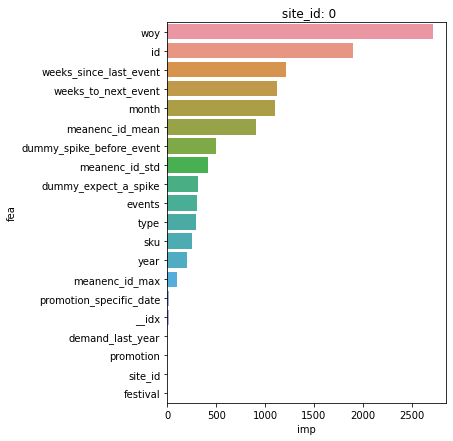

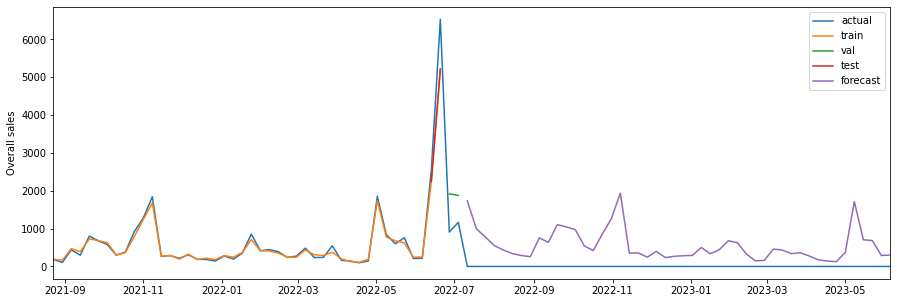

/tmp/ipykernel_3018487/1642674522.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_3018487/1642674522.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_3018487/1642674522.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_3018487/1642674522.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_3018487/164267452

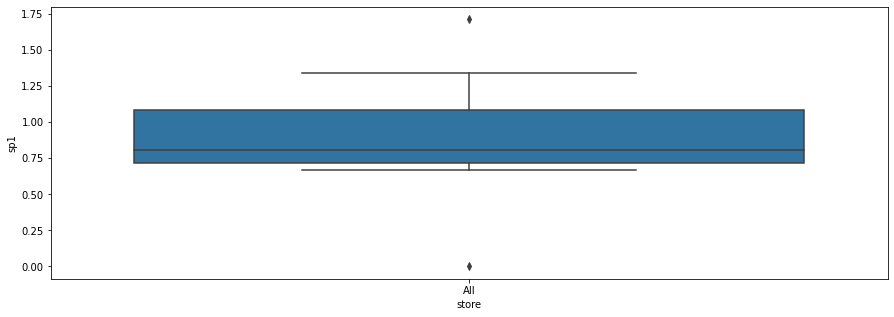

In [47]:
predict_df,results_wow,results = single_lgbm_per_store(features_df, model_name, val_dates, test_dates, forecast_dates)


In [48]:
predict_df.ts.unique()

Index(['ts', 'id', 'y', 'sku', '__idx', 'year', 'month', 'woy', 'events', 'type', 'festival', 'promotion', 'promotion_specific_date', 'weeks_since_last_event', 'weeks_to_next_event', 'demand_last_year', 'dummy_spike_before_event', 'dummy_expect_a_spike', 'site_id', 'meanenc_id_mean', 'meanenc_id_std', 'meanenc_id_max', 'yhat', 'model'], dtype='object')

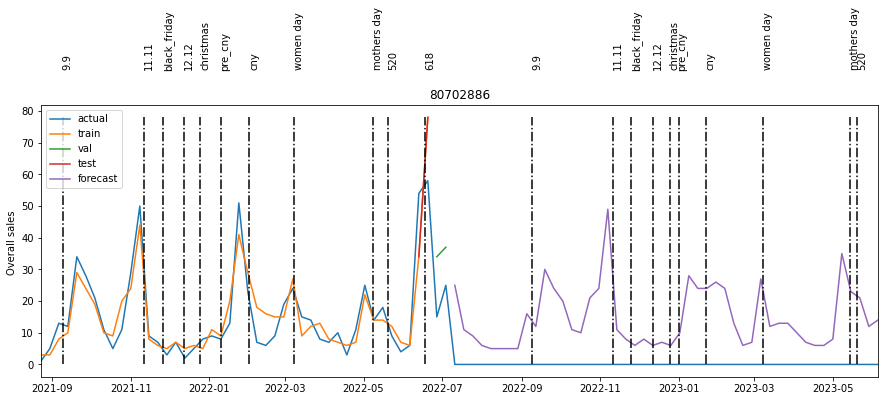

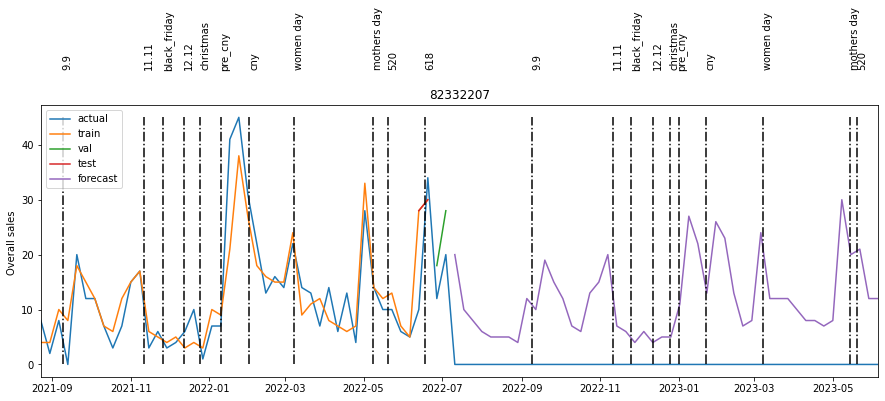

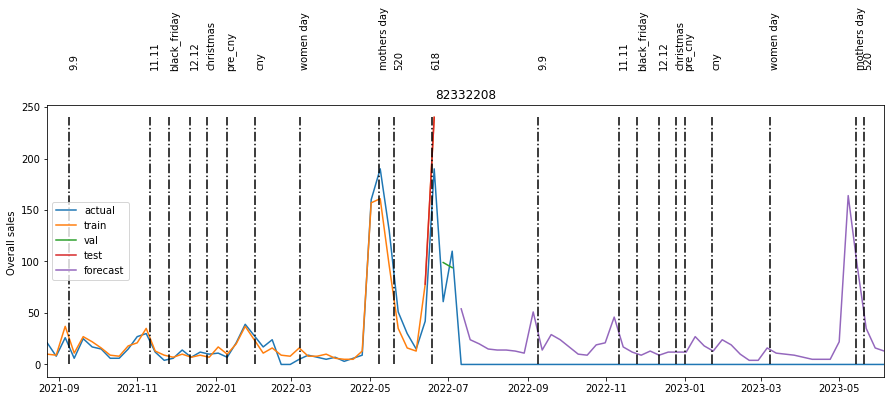

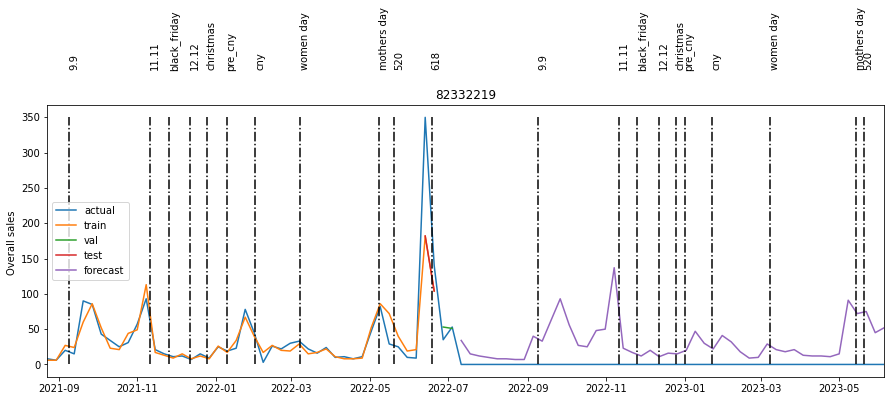

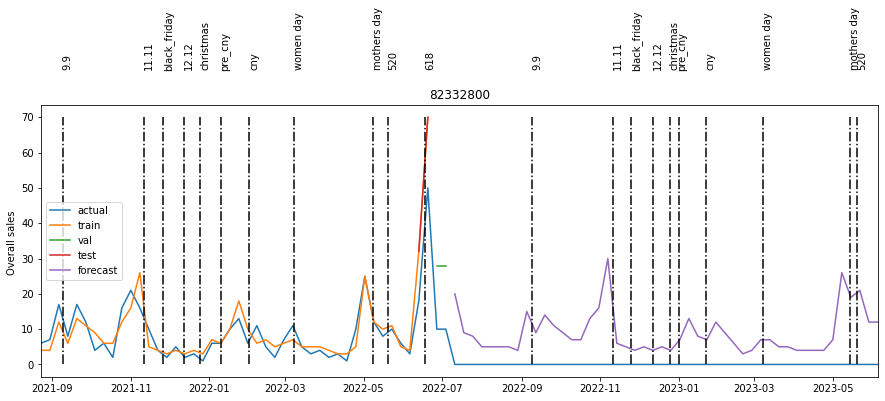

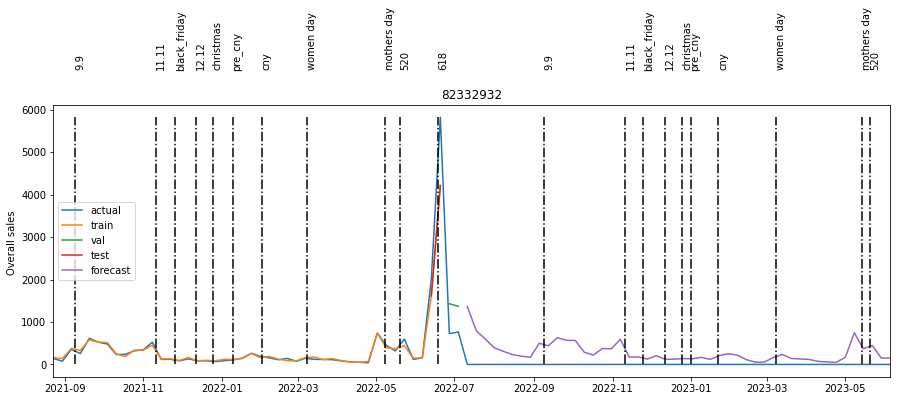

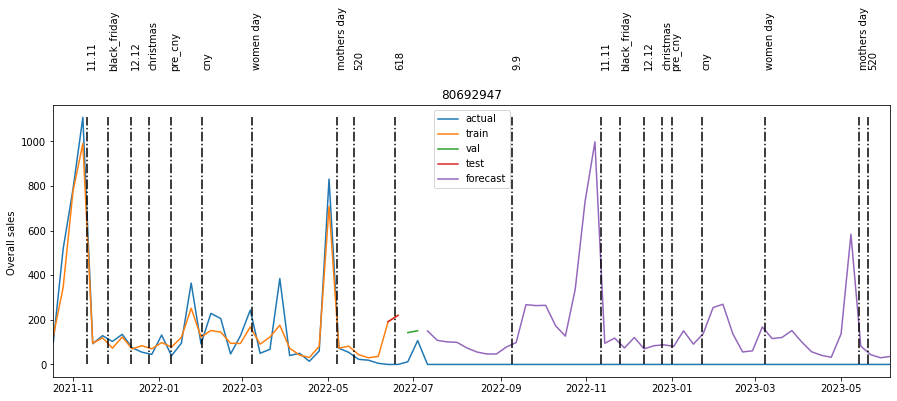

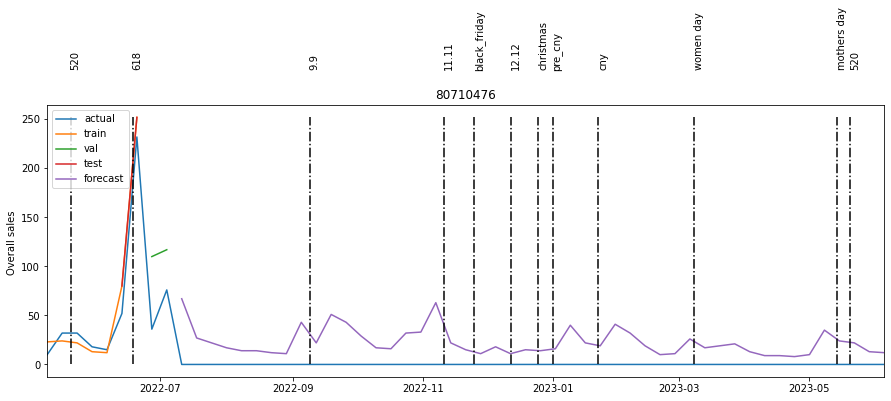

In [49]:
skus =  predict_df.sku.unique()

for this_sku in skus :
    this_ts = predict_df[predict_df['sku'] == this_sku]
    ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
    train = ts.loc[ts.ts < all_dates["val"][0]]
    val = ts.loc[ts.ts.isin(all_dates["val"])]
    test = ts.loc[ts.ts.isin(all_dates["test"])]
    forecasts = ts.loc[ts.ts.isin(all_dates["forecast"])]

    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")

    plt.plot(train.ts, train.yhat, label="train")


    if(val.shape[0] ==1):
        plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
    else:
        plt.plot(val.ts, val.yhat, label="val")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")


    plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
    for i in range(len(events)):
        plt.plot([events.ds[i], events.ds[i]], [0, _max], "k-.")
        if (events.ds[i] > ts.ts.min()) and (events.ds[i] < ts.ts.max()):
            plt.text(events.ds[i], _max*1.2, events.holiday[i], rotation=90)
    plt.xlim([ts.ts.min(), ts.ts.max()])
   # plt.ylim([0, predict_df.yhat.max()])
    plt.ylabel("Overall sales ")
    plt.title(this_sku)
    plt.legend()
    plt.show()

In [30]:
predict_df["ts"] = predict_df["ts"].astype("datetime64[ns]")
predict_df["id"] = predict_df["id"].astype("uint64")
predict_df["y"] = predict_df["y"].astype("float64")

test_df = predict_df.loc[predict_df.ts.isin(test_dates)].reset_index(drop=True)
val_df = predict_df.loc[predict_df.ts.isin(val_dates)].reset_index(drop=True)
predict_df = predict_df.loc[predict_df.ts.isin(forecast_dates)].reset_index(drop=True)
predict_df = predict_df[["ts", "id", "yhat"]].copy()
predict_df.rename(columns={"yhat": "y"}, inplace=True)
test_df = test_df[["ts", "id", "yhat"]].copy()
test_df.rename(columns={"yhat": "y"}, inplace=True)

val_df = val_df[["ts", "id", "yhat"]].copy()
val_df.rename(columns={"yhat": "y"}, inplace=True)

valid_df = lambda df : all([x in df.columns for x in ['ts', 'id', 'y']])


In [31]:

## Test df structure
if not valid_df(test_df):
    raise ValueError("Test Dataframe columns are not compliant")
    
## Predict df structure
if not valid_df(predict_df):
    raise ValueError("Predict Dataframe columns are not compliant")
    
def save_parquet(data, file_path, index=None):
    data = data[['ts', 'id', 'y']]
    mapping = {c: str for c in data.columns if data[c].dtype == object}
    data.astype(mapping).to_parquet(file_path, index=index)
    return file_path

# replace df below with dataframe with test and prediction outputs
predict_ts_path = save_parquet(predict_df, predict_ts_path, False)
test_ts_path = save_parquet(test_df, test_ts_path, False)
val_ts_path = save_parquet(val_df, validate_ts_path, False)